In [241]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [242]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits
#from mpl_toolkits.basemap import Basemap
import pandas as pd
import xarray as xr
import Nio
print (Nio.__version__)
#import seaborn as seabornInstance
from scipy import stats
#import sklearn

print("python version:")
import platform
print(platform.python_version())

1.5.5
python version:
3.7.3


In [243]:
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# Load Data

In [244]:
dat = xr.open_dataset('/global/scratch/medhap02/ISMData/ERA5_MSLP_SST_Td_tas_Jan1979toMay2020.grib',engine='pynio')

sst = dat['SSTK_GDS0_SFC_S123']
sst = sst.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

slp = dat['MSL_GDS0_SFC_S123']
slp = slp.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

In [245]:
msedat = xr.open_dataset('/global/scratch/medhap02/ISMData/MSE.ERA5.2meter.mon.mean.jan1979june2020.nc')
mse = msedat['__xarray_dataarray_variable__']
mse = mse.rename({'g0_lon_2':'lon', 'g0_lat_1':'lat', 'initial_time0_hours':'time'})

In [246]:
precipdat = xr.open_dataset('/global/scratch/medhap02/ISMData/pALLIN.nc', decode_times=False)
#print(precipdat)
time = pd.date_range('1871-02-01', freq='M', periods=1752)

precip = precipdat['precip']
precip['time'] = time

def is_jjas(month):
    return (month >= 6) & (month <= 9)

precipJJAS = precip.sel(time=is_jjas(precip['time.month'])).groupby('time.year').sum(dim='time')

## add IMD rainfall for 2012 - 2019 to observed time series

(2000, 2020)

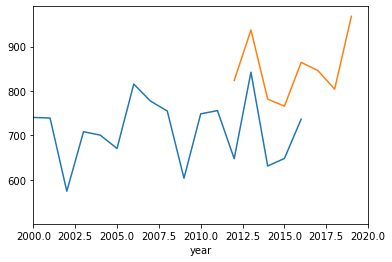

In [247]:
pIMDJJASupdateArray = np.array([823.6, 937.4, 781.7, 765.8, 864.4, 845.9, 804.1, 968.3] )
yearUpdate = np.arange(2012,2020)

# 2012 - 2018 values are from IMD reports obtained from their Hydromet division,
#  Customized Rainfall Information System (CRIS), 
#  http://hydro.imd.gov.in/hydrometweb/(S(gk24v0qwwwzr5hqr335i0q55))/landing.aspx#
#  2019 report not yet available so obtained from news articles citing IMD,
#  https://weather.com/en-IN/india/monsoon/news/2019-09-30-wettest-september-india-records-highest-monsoon-rainfall-25-years
#
pIMDJJASnormals = 886.9
pIMDJJASupdate = xr.DataArray(pIMDJJASupdateArray,coords={'year':yearUpdate},dims=['year'])
#pIMDJJAS = xr.concat([ptmpJJAS,pIMDJJASupdate],dim='year')
precipJJAS.plot()
pIMDJJASupdate.plot()
plt.xlim(2000,2020)

# EPT

In [248]:
#EP-ENSOpredictor
#(30n-30s, 155-175e)
#(10n-10s, 115-80w)

#DSST1
latrange1 = sst.sel(lat = slice(30, -30)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = sst.sel(lat = slice(30, -30), lon = slice(155, 175), time = (sst['time.month']==3))
marchSST1 = marchdata1.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean1 = (marchSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(30, -30), lon = slice(155, 175), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

marchmean1.time.data = maymean1.time.data
DSST1 = maymean1 - marchmean1

#DSST2
latrange2 = sst.sel(lat = slice(10, -10)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = sst.sel(lat = slice(10, -10), lon = slice(245, 280), time = (sst['time.month']==3))
marchSST2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = (marchSST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

maydata2 = sst.sel(lat = slice(10, -10), lon = slice(245, 280), time = (sst['time.month']==5))
maySST2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = (maySST2*weights2).mean({'lon', 'lat'})/weights2.mean() - 273.15

marchmean2.time.data = maymean2.time.data
DSST2 = (maymean2 - marchmean2)

EPTinitial = DSST1 - DSST2
EPTstd = 0.514143
EPTmean = 0.38594
EPTnew = (EPTinitial - EPTmean)/EPTstd

# CPT

In [249]:
#CP-ENSOpredictor
#(55-5s, 175e-155w)

#DSST
latrange1 = sst.sel(lat = slice(-5, -55)).lat
weights1 = np.cos(latrange1*np.pi/180)

aprildata1 = sst.sel(lat = slice(-5, -55), lon = slice(175, 205), time = (sst['time.month']==4))
aprilSST1 = aprildata1.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean1 = (aprilSST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

maydata1 = sst.sel(lat = slice(-5, -55), lon = slice(175, 205), time = (sst['time.month']==5))
maySST1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (maySST1*weights1).mean({'lon', 'lat'})/weights1.mean() - 273.15

aprilmean1.time.data = maymean1.time.data

CPTinitial = maymean1 - aprilmean1
CPTstd = 0.152151
CPTmean = -0.931681
CPTnew = (CPTinitial - CPTmean)/CPTstd

# PSH

In [250]:
#mega-ENSOpredictor
#(20-45s, 145-80w)
#(15-35n, 170-125w)
#(0-20n, 40-120e)

#NPcalculation
latrange1 = slp.sel(lat = slice(-20, -45)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = slp.sel(lat = slice(-20, -45), lon = slice(215, 260), time = (slp['time.month']==3))
marchSLP1 = marchdata1.sel(time=slice('1979-03-01','2020-03-01'))
marchmean1 = ((marchSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

aprildata1 = slp.sel(lat = slice(-20, -45), lon = slice(215, 260), time = (slp['time.month']==4))
aprilSLP1 = aprildata1.sel(time=slice('1979-04-01','2020-04-01'))
aprilmean1 = ((aprilSLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

maydata1 = slp.sel(lat = slice(-20, -45), lon = slice(215, 260), time = (slp['time.month']==5))
maySLP1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = ((maySLP1*weights1).mean({'lon', 'lat'})/weights1.mean())

marchmean1.time.data = maymean1.time.data
aprilmean1.time.data = maymean1.time.data
NP = ((marchmean1 + aprilmean1 + maymean1)/3)

#SPcalculation
latrange2 = slp.sel(lat = slice(35, 15)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = slp.sel(lat = slice(35, 15), lon = slice(190, 235), time = (slp['time.month']==3))
marchSLP2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = ((marchSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

aprildata2 = slp.sel(lat = slice(35, 15), lon = slice(190, 235), time = (slp['time.month']==4))
aprilSLP2 = aprildata2.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean2 = ((aprilSLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = slp.sel(lat = slice(35, 15), lon = slice(190, 235), time = (slp['time.month']==5))
maySLP2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = ((maySLP2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
aprilmean2.time.data = maymean2.time.data
SP = ((marchmean2 + aprilmean2 + maymean2)/3)

NParea = (25*weights1.mean() * 45)
SParea = (20*weights2.mean() * 45)
Pacific = ((NP * NParea) + (SP * SParea))/(NParea + SParea)

#EQindia
latrange3 = slp.sel(lat = slice(20, 0)).lat
weights3 = np.cos(latrange3*np.pi/180)

marchdata3 = slp.sel(lat = slice(20, 0), lon = slice(40, 120), time = (slp['time.month']==3))
marchSLP3 = marchdata3.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean3 = (marchSLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

aprildata3 = slp.sel(lat = slice(20, 0), lon = slice(40, 120), time = (slp['time.month']==4))
aprilSLP3 = aprildata3.sel(time = slice('1979-04-01', '2020-04-01'))
aprilmean3 = (aprilSLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

maydata3 = slp.sel(lat = slice(20, 0), lon = slice(40, 120), time = (slp['time.month']==5))
maySLP3 = maydata3.sel(time = slice('1979-05-01', '2020-05-01'))
maymean3 = (maySLP3*weights3).mean({'lon', 'lat'})/weights3.mean()

marchmean3.time.data = maymean3.time.data
aprilmean3.time.data = maymean3.time.data

EQindia = (marchmean3 + aprilmean3 + maymean3)/3

PSHinitial = Pacific - EQindia
PSHstd = 118.435818
PSHmean = 806.662506
PSHnew = (PSHinitial - PSHmean)/PSHstd

# MSE

In [251]:
#MSE
#(0-25n, 45-70e)
#(20-40n, 70-90e)
#(45-70n, 95e-150w)

#MSEleft
latrange1 = mse.sel(lat = slice(25, 0)).lat
weights1 = np.cos(latrange1*np.pi/180)

marchdata1 = mse.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse['time.month']==3))
marchMSE1 = marchdata1.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean1 = (marchMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

maydata1 = mse.sel(lat = slice(25, 0), lon = slice(45, 70), time = (mse['time.month']==5))
mayMSE1 = maydata1.sel(time = slice('1979-05-01', '2020-05-01'))
maymean1 = (mayMSE1*weights1).mean({'lon', 'lat'})/weights1.mean()

marchmean1.time.data = maymean1.time.data
MSEleft = maymean1 - marchmean1

#MSEright
latrange2 = mse.sel(lat = slice(40, 20)).lat
weights2 = np.cos(latrange2*np.pi/180)

marchdata2 = mse.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse['time.month']==3))
marchMSE2 = marchdata2.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean2 = ((marchMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

maydata2 = mse.sel(lat = slice(40, 20), lon = slice(70, 90), time = (mse['time.month']==5))
mayMSE2 = maydata2.sel(time = slice('1979-05-01', '2020-05-01'))
maymean2 = ((mayMSE2*weights2).mean({'lon', 'lat'})/weights2.mean())

marchmean2.time.data = maymean2.time.data
MSEright = maymean2 - marchmean2

#MSERussia
latrange3 = mse.sel(lat = slice(70, 45)).lat
weights3 = np.cos(latrange3*np.pi/180)

marchdata3 = mse.sel(lat = slice(70, 45), lon = slice(95, 210), time = (mse['time.month']==3))
marchMSE3 = marchdata3.sel(time = slice('1979-03-01', '2020-03-01'))
marchmean3 = (marchMSE3*weights3).mean({'lon', 'lat'})/weights3.mean()

maydata3 = mse.sel(lat = slice(70, 45), lon = slice(95, 210), time = (mse['time.month']==5))
mayMSE3 = maydata3.sel(time = slice('1979-05-01', '2020-05-01'))
maymean3 = (mayMSE3*weights3).mean({'lon', 'lat'})/weights3.mean()

marchmean3.time.data = maymean3.time.data
MSErussia = maymean3 - marchmean3

Leftarea = (25*weights1.mean() * 25)
Rightarea = (20*weights2.mean() * 20)
Russiaarea = (25*weights2.mean() * 15)
MSEinitial = ((MSEleft * Leftarea) + (MSEright * Rightarea) + (MSErussia * Russiaarea))/(Leftarea + Rightarea + Russiaarea)
MSEstd = 1370.256777
MSEmean = 13267.877327
MSEnew = (MSEinitial - MSEmean)/MSEstd

In [252]:
rainfallgraph = precipJJAS.sel(year = slice('1979', '2020')).data
rainfallmeangraph = rainfallgraph.mean()
rainfallstdgraph = rainfallgraph.std()
rainfallmean = 721.93976
rainfallstd = 64.26583862304688

# Model

In [253]:
AIRI = 0.357*EPTnew + 0.290*CPTnew + 0.137*PSHnew + 0.161*MSEnew
AIRI

<xarray.DataArray (time: 42)>
array([-0.730163, -0.217506, -0.07685 , -0.432275,  0.190727,  0.40605 ,
        0.736311, -0.302047, -1.108585,  0.90333 ,  0.541282,  0.657872,
       -0.565125, -0.306802, -0.100217,  0.084465,  0.185649,  0.075091,
       -1.510533,  0.523824,  0.705383,  0.794111,  1.321574, -0.278071,
        0.476853,  0.734532, -0.800794,  0.806863,  1.176107,  0.378654,
       -0.124445,  0.863036,  0.686719,  0.410697,  0.815344,  0.17259 ,
       -0.825944,  0.649191,  0.12673 ,  0.006686, -0.125093,  0.026565])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01

In [254]:
final = (AIRI * rainfallstd) + rainfallmean
print(final)

<xarray.DataArray (time: 42)>
array([675.015226, 707.961525, 717.000953, 694.159242, 734.196963, 748.03493 ,
       769.259434, 702.528471, 650.695633, 779.993031, 756.725733, 764.218468,
       685.621545, 702.222855, 715.4992  , 727.367983, 733.870645, 726.765562,
       624.864108, 755.603779, 767.271817, 772.973947, 806.871811, 704.069289,
       752.585111, 769.14508 , 670.476068, 773.793499, 797.52327 , 746.274299,
       713.942186, 777.403518, 766.072335, 748.333522, 774.338554, 733.03141 ,
       668.859759, 763.660551, 730.084153, 722.36946 , 713.900573, 723.646976])
Coordinates:
  * time     (time) datetime64[ns] 1979-05-01 1980-05-01 ... 2020-05-01


In [255]:
#ranges for graphics and informations

modelyears = []
for x in range(42):
    modelyears.append(x+1979)
modelyears2 = []
for x in range(38):
    modelyears2.append(x+1979)
observedrainfall = []
for x in range(38):
    observedrainfall.append(float(precipJJAS[x+108]))
correlationfinal = []
for x in range(38):
    correlationfinal.append(final.data[x])

In [256]:
#correlation
correlation = stats.pearsonr(correlationfinal, observedrainfall)
correlation = correlation[0]
print("Correlation between Model and Rainfall", correlation)

Correlation between Model and Rainfall 0.4890447086700963


In [257]:
rmse = 27.929032
airivalue = AIRI.sel(time = slice('2020-05-01', '2020-05-01')).data
prediction2020 = final.sel(time = slice('2020-05-01', '2020-05-01')).data
prediction = (prediction2020[0]/rainfallmean)
bounds = (rmse/rainfallmean)

In [258]:
predictiontxt = ('2020 prediction: '+"{:0.3f}".format(prediction)+ "+/-"+ "{:0.3f}".format(bounds)+ " of normal")
print(predictiontxt)
correlationtxt = ('r(prediction,obs) = '+"{:0.2f}".format(correlation))
print(correlationtxt)

2020 prediction: 1.002+/-0.039 of normal
r(prediction,obs) = 0.49


# Final Information and Graphics

Text(1978, 550, 'r(prediction,obs) = 0.49')

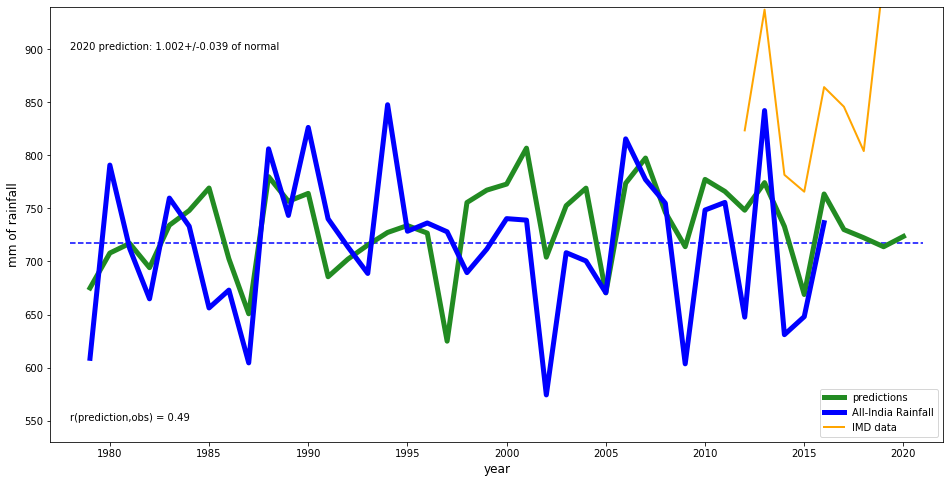

In [259]:
#print("2020 prediction", final.sel(time = slice('2020-05-01', '2020-05-01')))
plt.figure(figsize=(16,8))
plt.title('1979 - 2020 predictions', fontsize = 'xx-large')
plt.plot(modelyears, final, label = 'predictions', color = 'forestgreen',linewidth=5)
plt.plot(modelyears2, observedrainfall, label = 'All-India Rainfall', color = 'blue',linewidth=5)
pIMDJJASupdate.sel(year=slice('1979','2020')).plot(linewidth=2,color='orange',label='IMD data')

axes = plt.gca()
axes.set_xlim([1977, 2022])
axes.set_ylim([530, 940])
plt.xlabel('year', fontsize = 'large')
plt.ylabel('mm of rainfall', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(rainfallmeangraph,1978,2021,linestyles='dashed',colors='blue')

plt.text(1978,900,predictiontxt)
plt.text(1978,550,correlationtxt)

In [260]:
print("Root Mean Square Error:", rmse)
print()
print("Rainfall Standard Deviation for Training Period:",rainfallstd)
print("Rainfall Mean for Training Period:", rainfallmean)
print()
print("2020 Prediction",prediction2020[0],"mm of rainfall")
print("Correlation between Model and Rainfall", correlation)
print("Prediction's Standard Deviation Above or Below the Mean:", airivalue[0])

Root Mean Square Error: 27.929032

Rainfall Standard Deviation for Training Period: 64.26583862304688
Rainfall Mean for Training Period: 721.93976

2020 Prediction 723.6469763856323 mm of rainfall
Correlation between Model and Rainfall 0.4890447086700963
Prediction's Standard Deviation Above or Below the Mean: 0.02656491259137081


## Instead plot results as fraction of long-term mean
This helps with the issue of IITM and IMD data having different long-term means.
Add error bar representing the RMSE between the two different input datasets for our predictions (HadSLP+NOAASST vs ERA5)

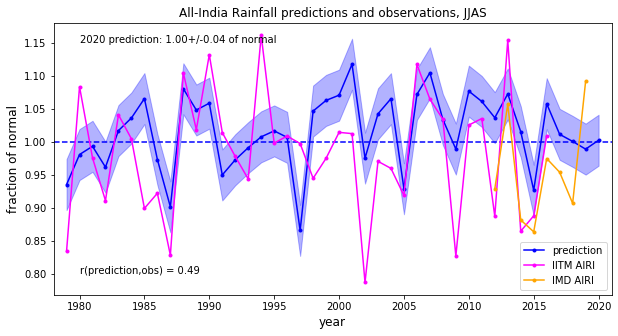

In [261]:
plt.figure(figsize=(10,5))
plt.fill_between(modelyears,(final+rmse)/rainfallmean,(final-rmse)/rainfallmean,color='blue',alpha=0.3)
plt.plot(modelyears, final/rainfallmean, label = 'prediction', color = 'blue',marker='.')
#plt.plot(modelyears2, observedrainfall/, label = 'All-India Rainfall', color = 'blue',linewidth=5)
IITMmean = precipJJAS.sel(year=slice(1951,2000)).mean()
IMDmean = 886.9  # from the IMD 2013 monsoon report for 1951-2000 normals, JJAS
(precipJJAS/IITMmean).sel(year=slice('1979','2020')).plot(color='magenta',marker='.',label='IITM AIRI')
(pIMDJJASupdate/IMDmean).sel(year=slice('1979','2020')).plot(color='orange',marker='.',label='IMD AIRI')
plt.xlabel('year', fontsize = 'large')
plt.ylabel('fraction of normal', fontsize = 'large')
plt.legend(loc='lower right')
plt.hlines(1.0,1978,2021,linestyles='dashed',color='blue')
plt.xlim((1978,2021))
plt.title('All-India Rainfall predictions and observations, JJAS')
plt.text(1980,0.80,'r(prediction,obs) = '+"{:0.2f}".format(correlation))
plt.text(1980,1.15,'2020 prediction: '+"{:0.2f}".format(prediction2020[0]/rainfallmean) + "+/-" + "{:0.2f}".format(rmse/rainfallmean)+" of normal")
plt.savefig('AIRI_forecast2020_WangEtAl2015model.pdf')

In [262]:
# Copyright (c) 2020 Medha Palavalli.